# Semantic Data Analysis: RWTH-PHOENIX-Weather 2014 Dataset

**Dataset**: RWTH-PHOENIX-Weather 2014 (German Sign Language)

**Purpose**: Pre-modeling data exploration to understand data semantics before architecture design

**Author**: Kgomotso Larry S.


In [3]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import platform
import json
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plotting style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# Get system information
print(f"Python version: {platform.python_version()}")
print(f"Platform: {platform.platform()}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# Set random seed for reproducibility
np.random.seed(42)


Python version: 3.9.13
Platform: Windows-10-10.0.26200-SP0
NumPy version: 1.26.3
Pandas version: 2.3.3


## 1. Dataset Overview and Statistics


In [4]:
# Define data paths
DATA_ROOT = Path('../data')
RAW_DATA = DATA_ROOT / 'raw_data' / 'phoenix-2014-multisigner'
ANNOTATIONS = RAW_DATA / 'annotations' / 'manual'
FRAMES_DIR = RAW_DATA / 'features' / 'fullFrame-210x260px'
MEDIAPIPE_FEATURES = DATA_ROOT / 'teacher_features' / 'mediapipe_full'

# Load annotations
train_df = pd.read_csv(ANNOTATIONS / 'train.corpus.csv', sep='|')
dev_df = pd.read_csv(ANNOTATIONS / 'dev.corpus.csv', sep='|')
test_df = pd.read_csv(ANNOTATIONS / 'test.corpus.csv', sep='|')

print("=== Dataset Overview ===")
print(f"Training sequences: {len(train_df)}")
print(f"Development sequences: {len(dev_df)}")
print(f"Test sequences: {len(test_df)}")
print(f"Total sequences: {len(train_df) + len(dev_df) + len(test_df)}")
print(f"\nUnique signers: {len(set(list(train_df['signer']) + list(dev_df['signer']) + list(test_df['signer'])))}")


=== Dataset Overview ===
Training sequences: 5672
Development sequences: 540
Test sequences: 629
Total sequences: 6841

Unique signers: 9


In [15]:
# Analyze vocabulary and sequence statistics
def analyze_annotations(df, split_name):
    # Tokenize annotations
    all_tokens = []
    sequence_lengths = []
    
    for annotation in df['annotation']:
        tokens = annotation.split()
        all_tokens.extend(tokens)
        sequence_lengths.append(len(tokens))
    
    vocab = set(all_tokens)
    
    return {
        'split': split_name,
        'num_sequences': len(df),
        'vocab_size': len(vocab),
        'total_tokens': len(all_tokens),
        'avg_seq_length': np.mean(sequence_lengths),
        'std_seq_length': np.std(sequence_lengths),
        'min_seq_length': np.min(sequence_lengths),
        'max_seq_length': np.max(sequence_lengths),
        'tokens': all_tokens,
        'sequence_lengths': sequence_lengths
    }

train_stats = analyze_annotations(train_df, 'Train')
dev_stats = analyze_annotations(dev_df, 'Dev')
test_stats = analyze_annotations(test_df, 'Test')

# Create summary dataframe
summary_df = pd.DataFrame([train_stats, dev_stats, test_stats])
print("======"*16)
print("Annotation Statistics\n")
print(summary_df[['split', 'num_sequences', 'vocab_size', 'avg_seq_length', 'std_seq_length', 
                  'min_seq_length', 'max_seq_length']].to_string(index=False))

# Overall vocabulary
all_vocab = set(train_stats['tokens'] + dev_stats['tokens'] + test_stats['tokens'])
print(f"\nTotal unique vocabulary size: {len(all_vocab)}")


Annotation Statistics

split  num_sequences  vocab_size  avg_seq_length  std_seq_length  min_seq_length  max_seq_length
Train           5672        1231       11.499824        3.579738               2              28
  Dev            540         460       10.259259        3.155742               3              23
 Test            629         496       10.340223        3.171112               3              21

Total unique vocabulary size: 1295


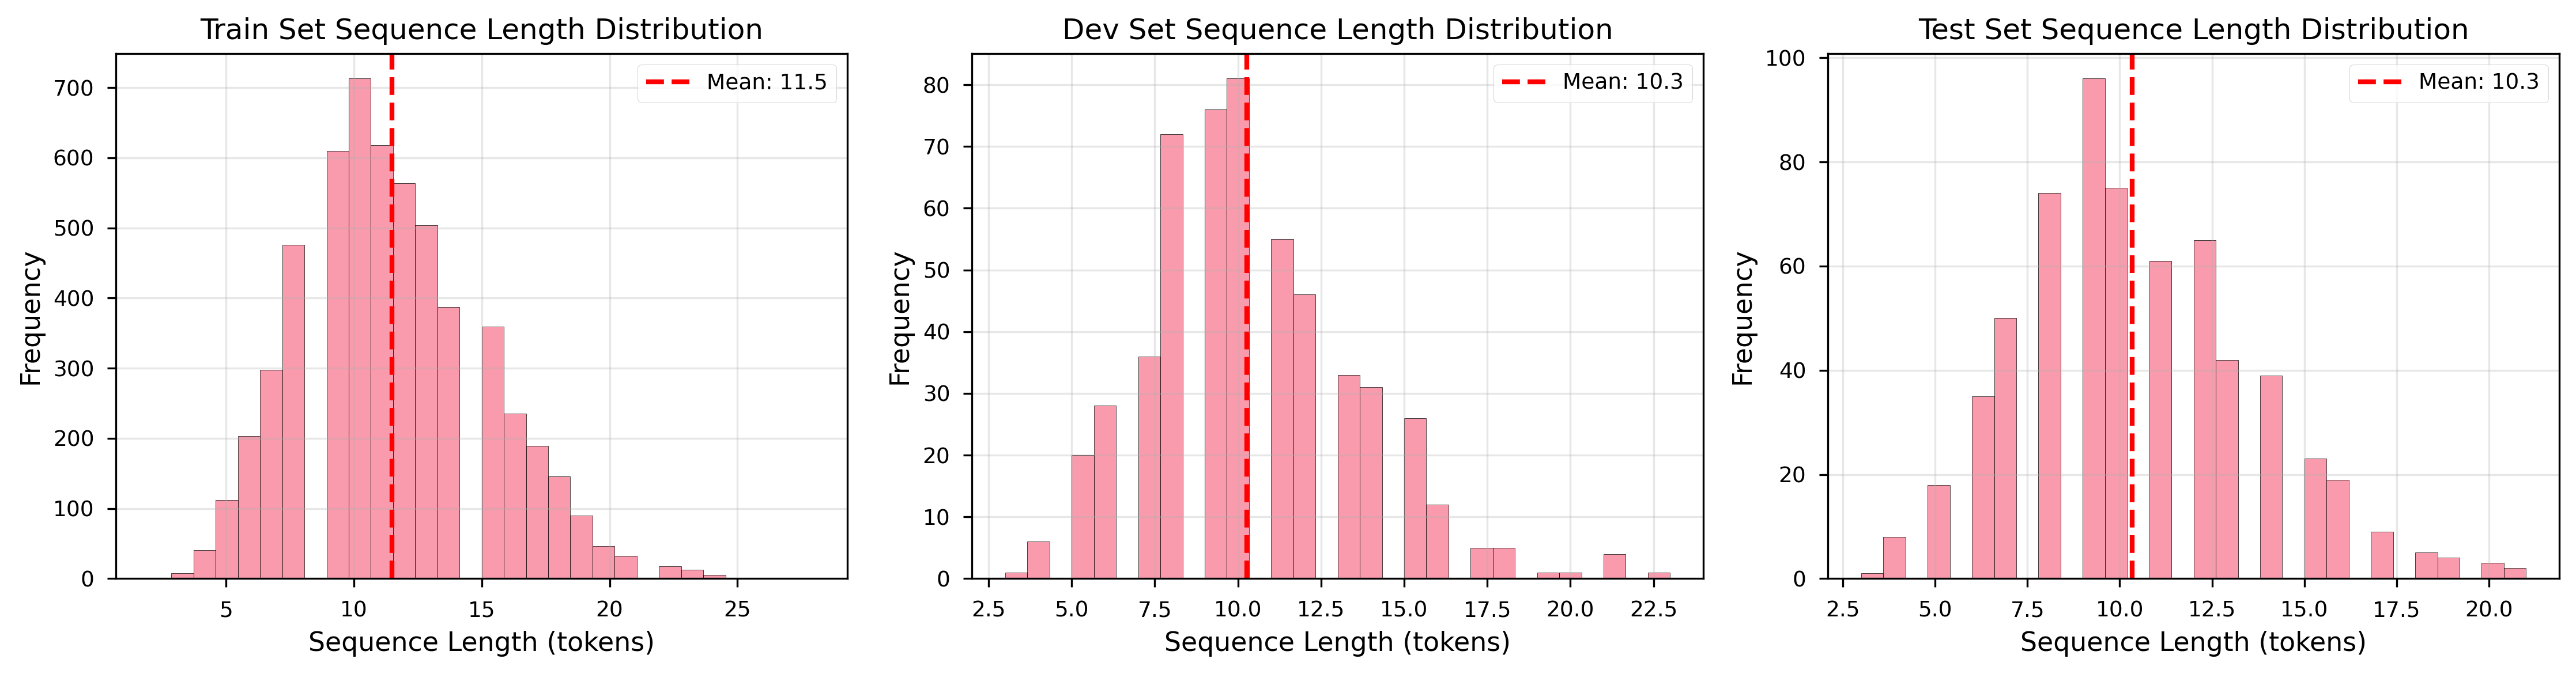

In [17]:
# Create output directory for figures
Path('figures').mkdir(exist_ok=True)

# Visualize sequence length distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (stats, title) in enumerate(zip([train_stats, dev_stats, test_stats], ['Train', 'Dev', 'Test'])):
    axes[idx].hist(stats['sequence_lengths'], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].axvline(stats['avg_seq_length'], color='red', linestyle='--', linewidth=2, label=f'Mean: {stats["avg_seq_length"]:.1f}')
    axes[idx].set_xlabel('Sequence Length (tokens)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{title} Set Sequence Length Distribution')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/split_sequence_length_distribution.png', bbox_inches='tight')
plt.show()


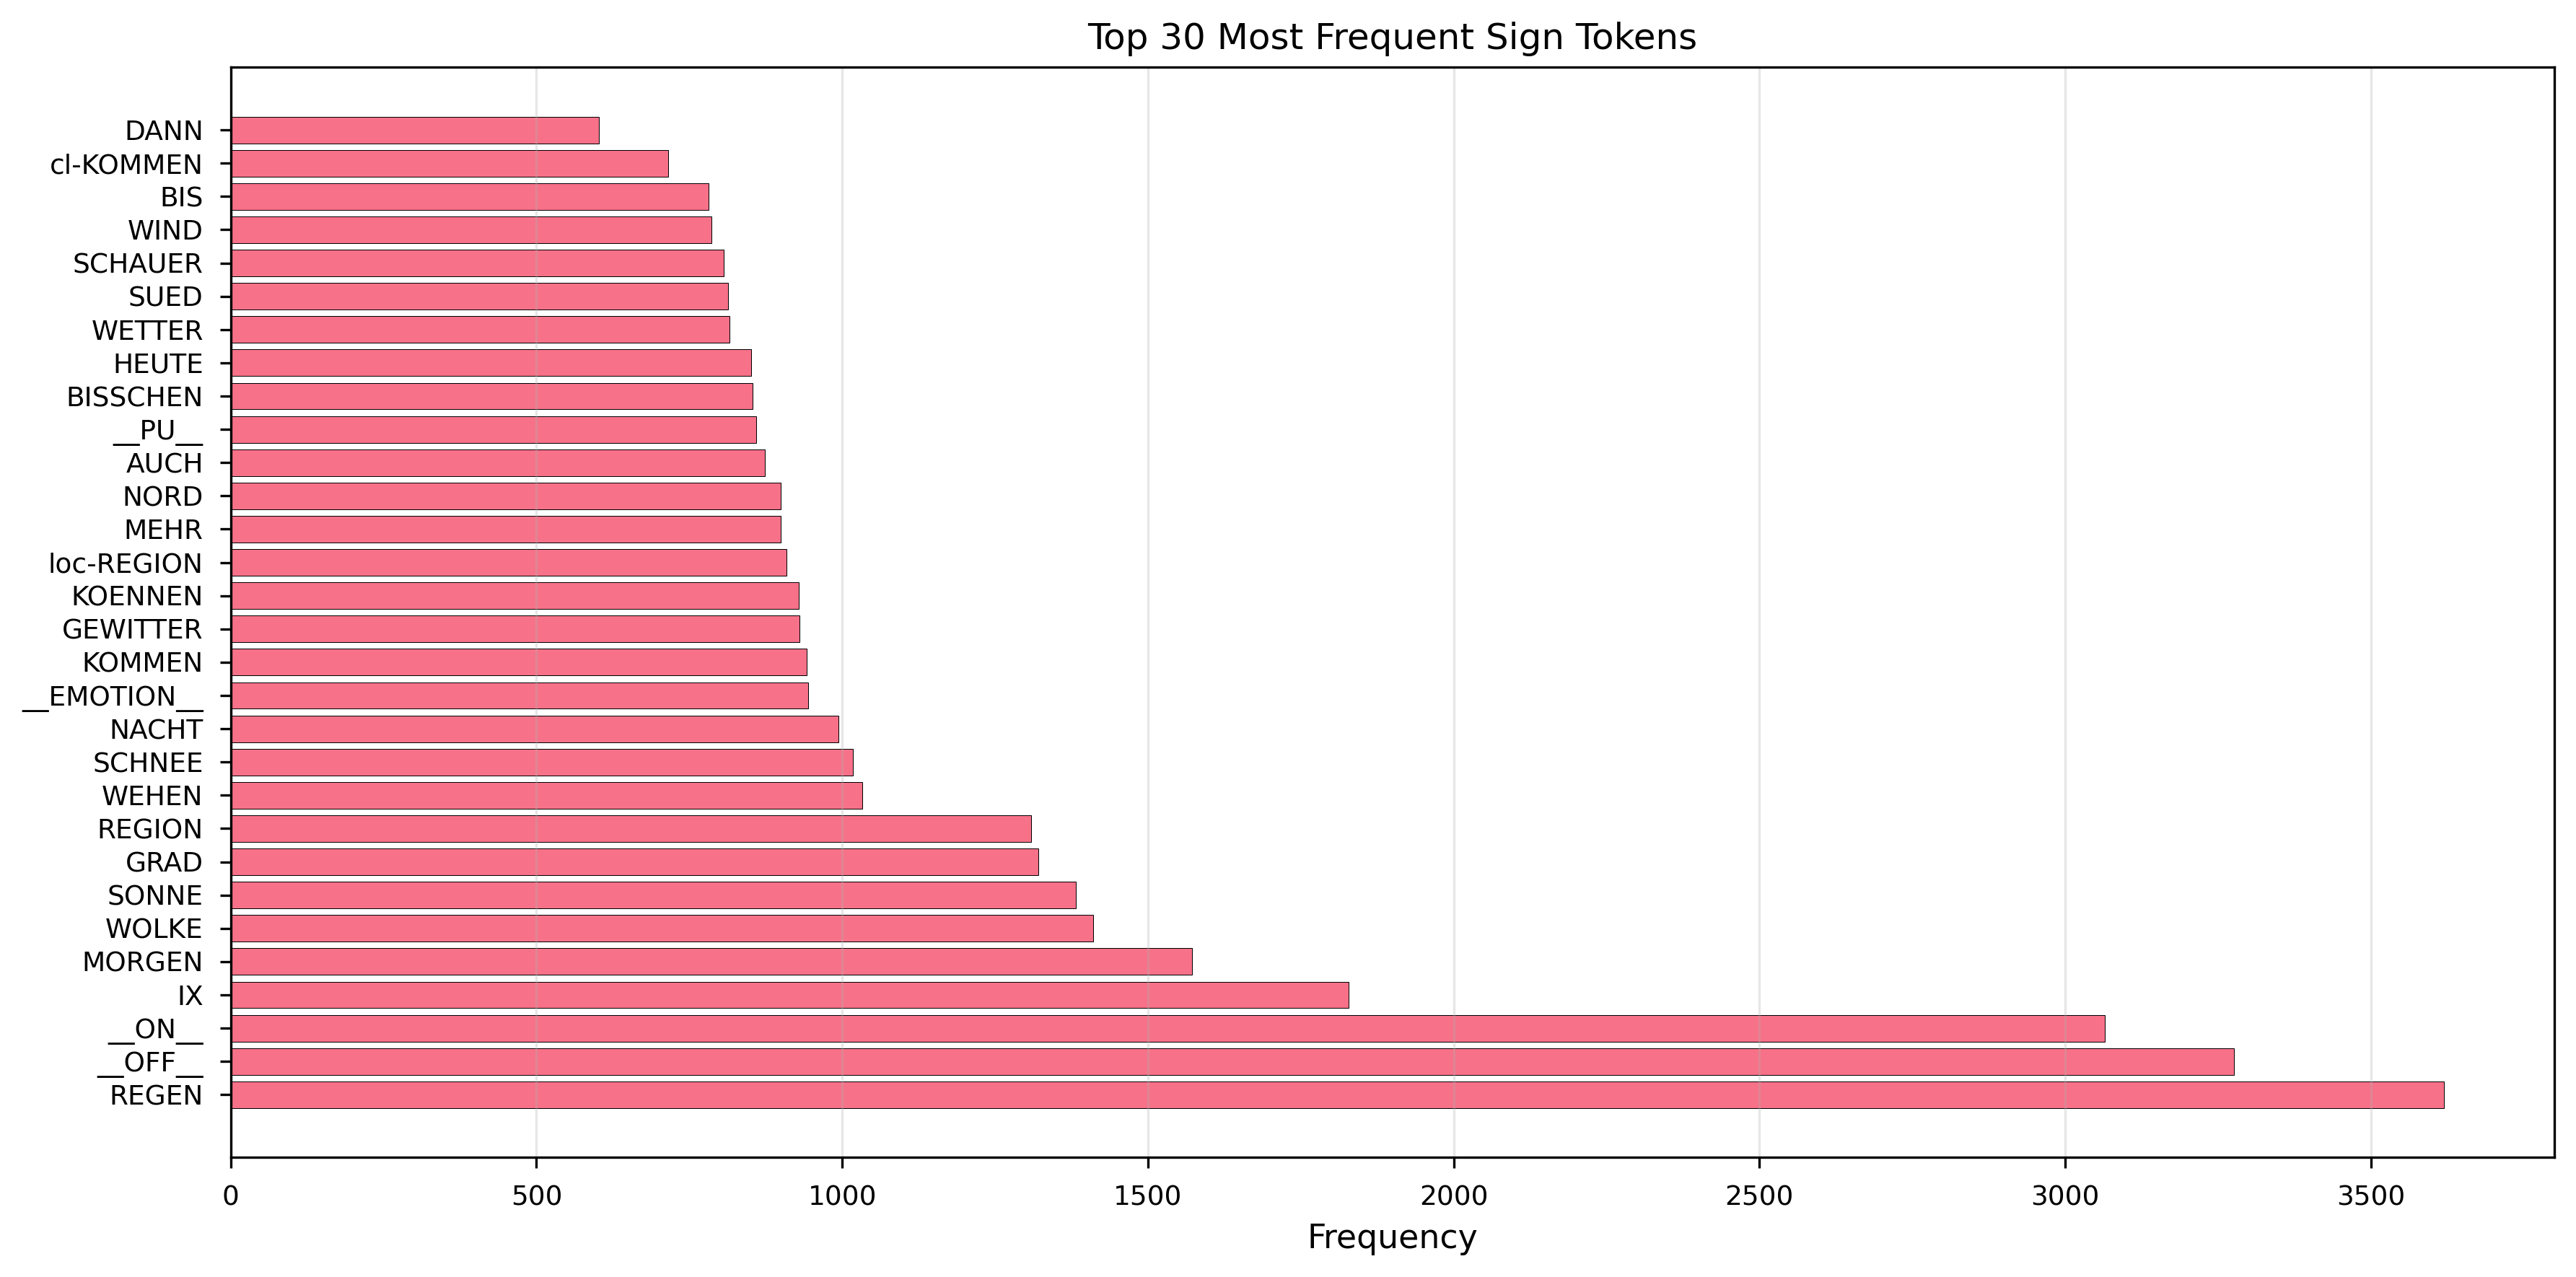

In [21]:
# Token frequency analysis
all_tokens = train_stats['tokens'] + dev_stats['tokens'] + test_stats['tokens']
token_counts = Counter(all_tokens)
most_common = token_counts.most_common(30)

fig, ax = plt.subplots(figsize=(12, 6))
tokens, counts = zip(*most_common)
ax.barh(range(len(tokens)), counts, edgecolor='black')
ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)
ax.set_xlabel('Frequency')
ax.set_title('Top 30 Most Frequent Sign Tokens')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('figures/token_frequency.png', bbox_inches='tight')
plt.show()


## 2. Raw Video Frame Analysis


In [28]:
from PIL import Image

# Sample frame analysis
def get_frame_count(video_id, split='train'):
    """Count frames for a video sequence - tries multiple path structures"""
    # Try different possible directory structures
    possible_paths = [
        FRAMES_DIR / split / video_id,  # Direct match
        FRAMES_DIR / split / video_id / '1',  # With subdirectory
        FRAMES_DIR / split / video_id.split('-')[0],  # Without suffix
    ]
    
    for frame_dir in possible_paths:
        if frame_dir.exists():
            frames = list(frame_dir.glob('*.png'))
            if len(frames) > 0:
                return len(frames)
    
    # If no direct match, try searching in parent directory
    parent_dir = FRAMES_DIR / split
    if parent_dir.exists():
        # Search for any directory containing the video_id
        matching_dirs = [d for d in parent_dir.iterdir() if d.is_dir() and video_id in d.name]
        for match_dir in matching_dirs:
            frames = list(match_dir.glob('**/*.png'))  # Recursive search
            if len(frames) > 0:
                return len(frames)
    
    return 0

# Analyze frame counts for a sample
sample_videos = train_df['id'].head(100)
frame_counts = []
found_videos = []

for video_id in sample_videos:
    count = get_frame_count(video_id, 'train')
    if count > 0:
        frame_counts.append(count)
        found_videos.append(video_id)

print(f"\n=== Frame Count Statistics ===")
print(f"Videos checked: {len(sample_videos)}")
print(f"Videos with frames found: {len(found_videos)}")

if len(frame_counts) > 0:
    print(f"\nAverage frames per video: {np.mean(frame_counts):.1f}")
    print(f"Std frames per video: {np.std(frame_counts):.1f}")
    print(f"Min frames: {np.min(frame_counts)}")
    print(f"Max frames: {np.max(frame_counts)}")
    
    # Show sample of found videos
    if len(found_videos) > 0:
        print(f"\nSample found videos (first 5): {found_videos[:5]}")
else:
    print("\n No video frames found. This could indicate:")
    print("   - Frame directory structure differs from expected")
    print("   - Frames are in a different location")
    print("   - Path needs adjustment")
    print(f"\n   Checking if frame directory exists: {FRAMES_DIR.exists()}")
    if FRAMES_DIR.exists():
        print(f"   Train subdirectory exists: {(FRAMES_DIR / 'train').exists()}")
        if (FRAMES_DIR / 'train').exists():
            sample_dirs = list((FRAMES_DIR / 'train').iterdir())[:5]
            print(f"\nSample directories in train: {[d.name for d in sample_dirs if d.is_dir()]}")



=== Frame Count Statistics ===
Videos checked: 100
Videos with frames found: 100

Average frames per video: 150.2
Std frames per video: 43.0
Min frames: 64
Max frames: 261

Sample found videos (first 5): ['01April_2010_Thursday_heute_default-0', '01April_2010_Thursday_heute_default-2', '01April_2010_Thursday_heute_default-3', '01April_2010_Thursday_heute_default-4', '01April_2010_Thursday_heute_default-6']



Visualizing sample sequence: 01April_2010_Thursday_heute_default-0


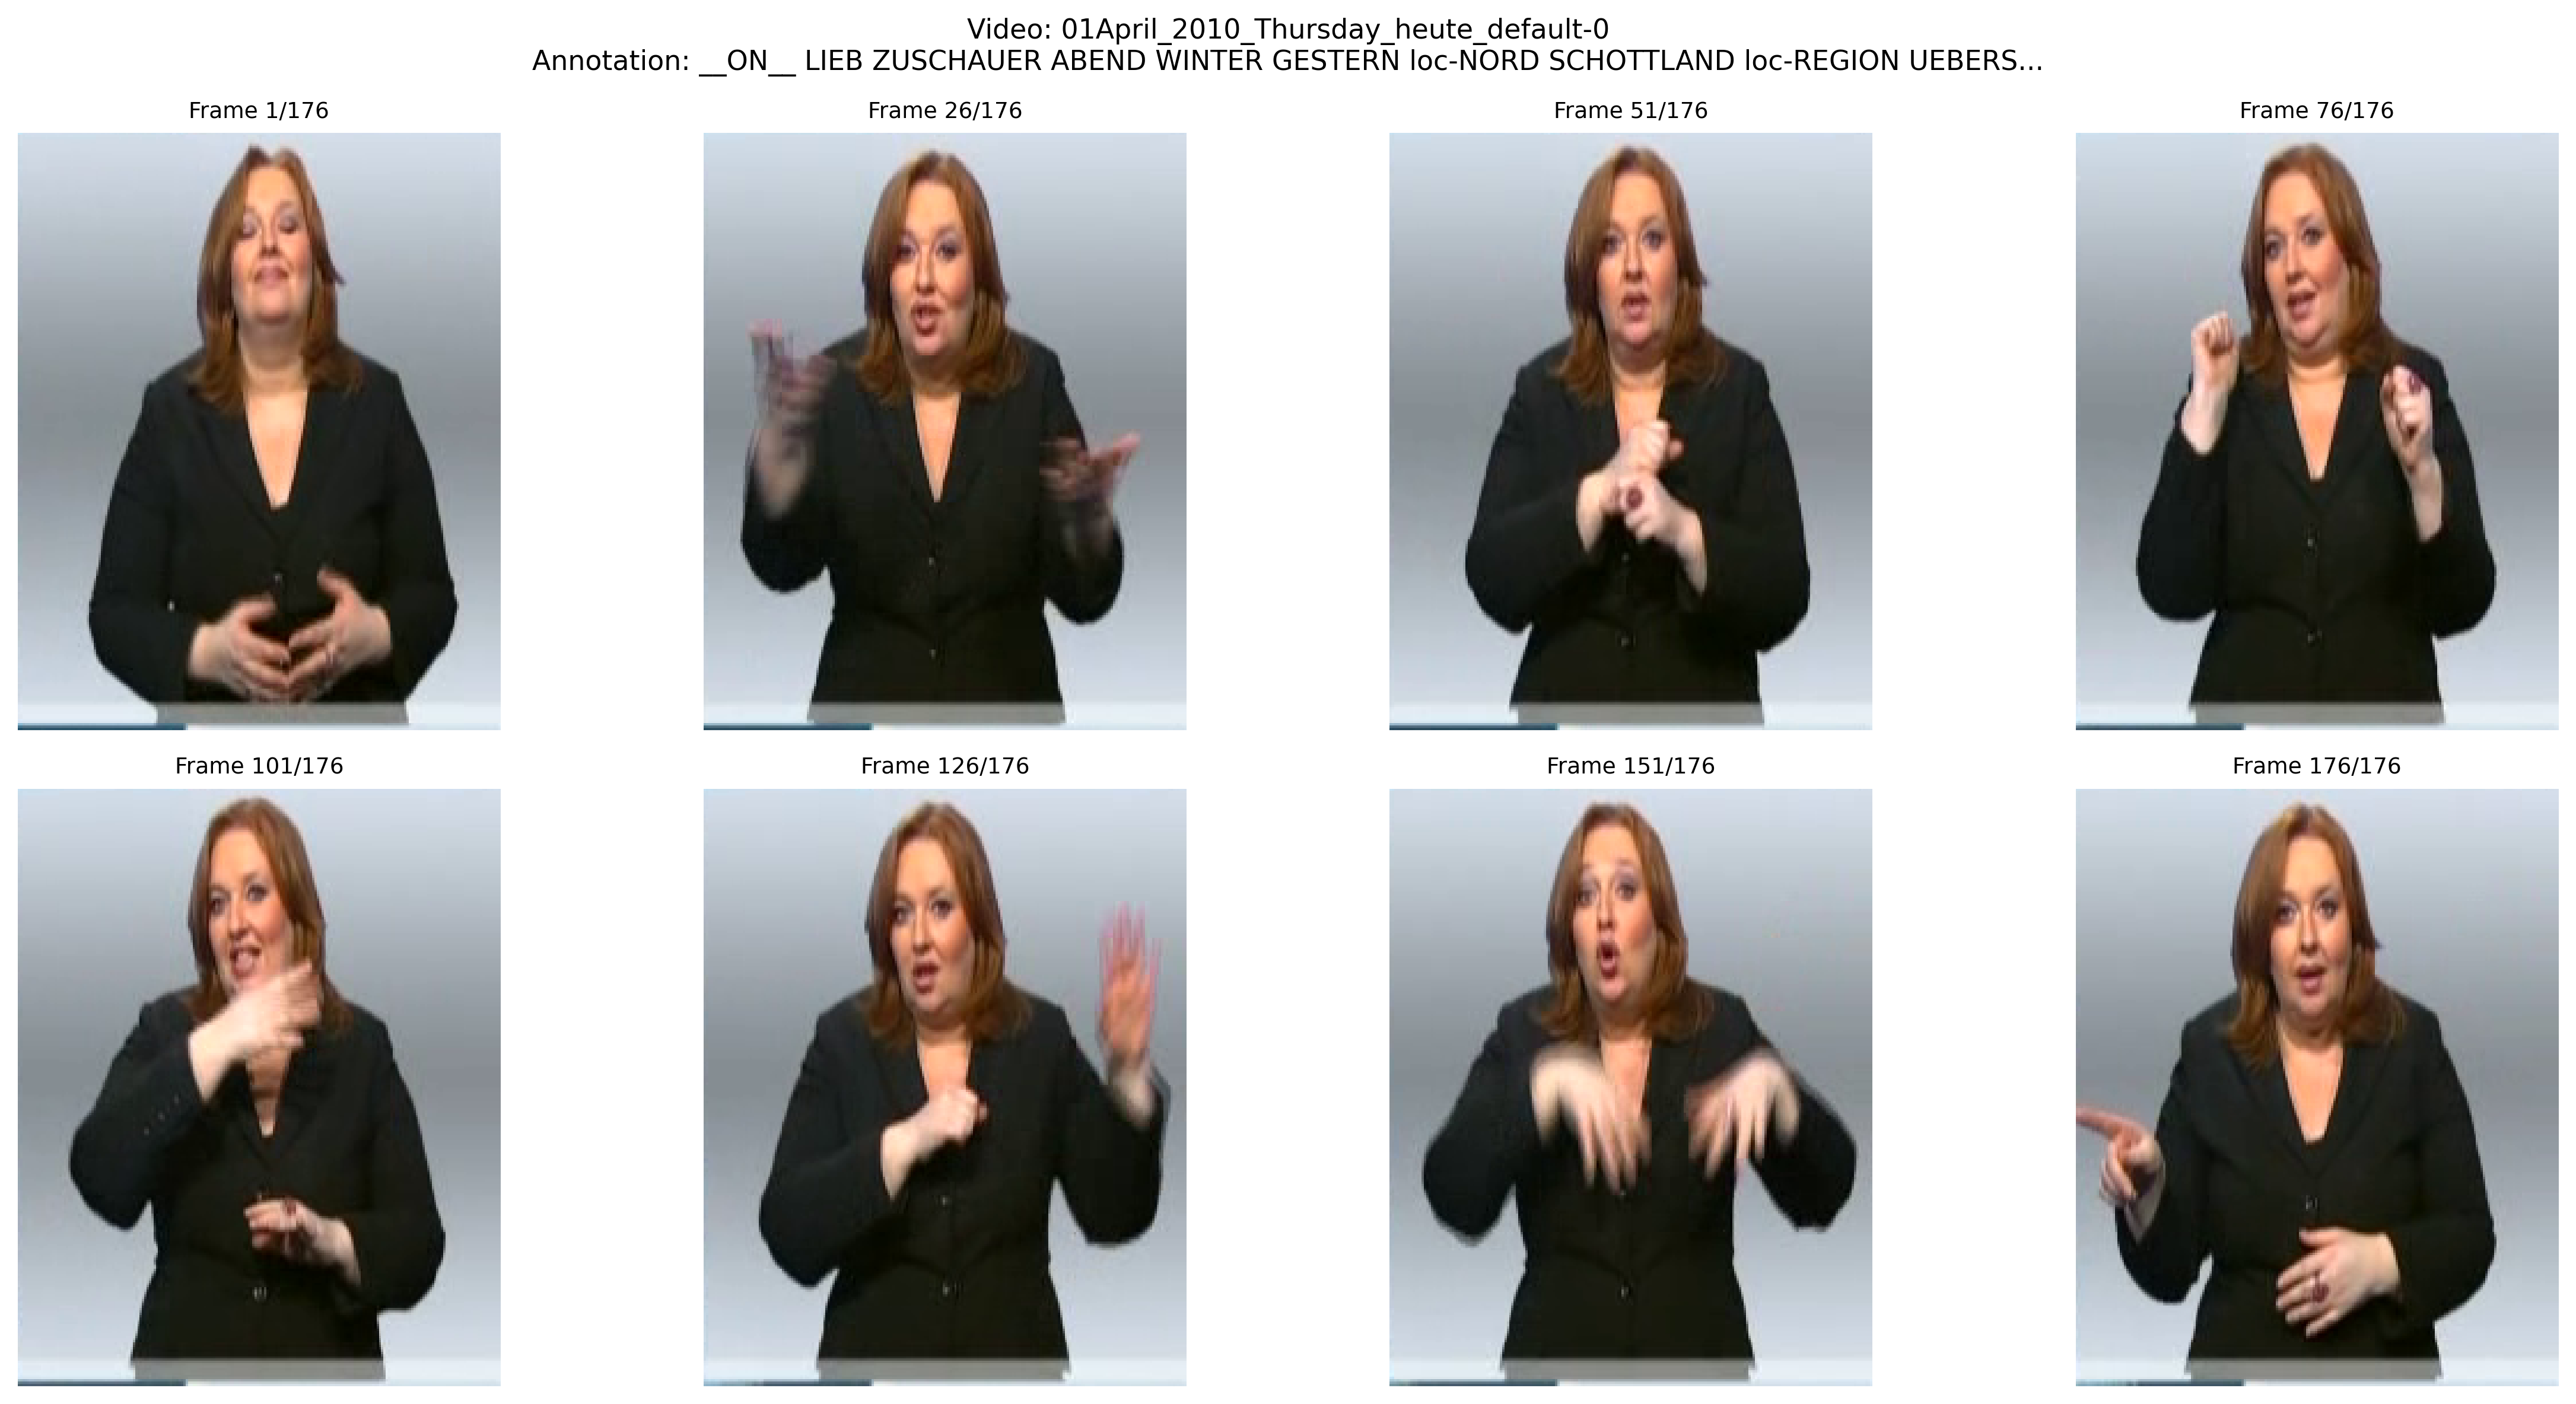

In [29]:
# Visualize sample frames from a sequence
def visualize_sample_sequence(video_id, split='train', num_frames=8):
    """Display a temporal sequence of frames"""
    # Try to find frames using the same logic as get_frame_count
    possible_paths = [
        FRAMES_DIR / split / video_id,
        FRAMES_DIR / split / video_id / '1',
        FRAMES_DIR / split / video_id.split('-')[0],
    ]
    
    frames = []
    for frame_dir in possible_paths:
        if frame_dir.exists():
            frames = sorted(list(frame_dir.glob('*.png')))
            if len(frames) > 0:
                break
    
    # If still no frames, try recursive search
    if len(frames) == 0:
        parent_dir = FRAMES_DIR / split
        if parent_dir.exists():
            matching_dirs = [d for d in parent_dir.iterdir() if d.is_dir() and video_id in d.name]
            for match_dir in matching_dirs:
                frames = sorted(list(match_dir.glob('**/*.png')))
                if len(frames) > 0:
                    break
    
    if len(frames) == 0:
        print(f"No frames found for video: {video_id}")
        print(f"   Tried paths: {[str(p) for p in possible_paths]}")
        return None
    
    # Sample frames evenly
    indices = np.linspace(0, len(frames)-1, num_frames, dtype=int)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, frame_idx in enumerate(indices):
        img = Image.open(frames[frame_idx])
        axes[idx].imshow(img, cmap='gray' if img.mode == 'L' else None)
        axes[idx].axis('off')
        axes[idx].set_title(f'Frame {frame_idx+1}/{len(frames)}', fontsize=9)
    
    # Get annotation
    annotation = train_df[train_df['id'] == video_id]['annotation'].values[0] if split == 'train' else None
    if annotation:
        fig.suptitle(f'Video: {video_id}\nAnnotation: {annotation[:80]}...', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'figures/sample_sequence_{video_id}.png', bbox_inches='tight')
    plt.show()
    return fig

# Visualize a sample sequence - try to find one that has frames
sample_video = train_df['id'].iloc[0]
if len(found_videos) > 0:
    sample_video = found_videos[0]
    print(f"\nVisualizing sample sequence: {sample_video}")
    visualize_sample_sequence(sample_video, split='train')
else:
    print(f"\nSkipping visualization - no frames found for sample videos")
    print(f"   This is expected if raw video frames are not available")
    print(f"   The MediaPipe features analysis will still work with the extracted features")


## 3. MediaPipe Feature Analysis


In [30]:
# Load and analyze MediaPipe features
def load_mediapipe_features(video_id, split='train'):
    """Load MediaPipe features for a video"""
    feature_path = MEDIAPIPE_FEATURES / split / f"{video_id}.npz"
    if feature_path.exists():
        data = np.load(feature_path, allow_pickle=True)
        return {
            'features': data['features'],
            'detection_masks': data['detection_masks'] if 'detection_masks' in data else None,
            'metadata': data['metadata'].item() if 'metadata' in data else None,
            'video_id': data['video_id'].item() if 'video_id' in data else video_id
        }
    return None

# Analyze feature structure
sample_features = load_mediapipe_features(sample_video, 'train')
if sample_features:
    print("=== MediaPipe Feature Structure ===")
    print(f"Features shape: {sample_features['features'].shape}")
    print(f"Features dtype: {sample_features['features'].dtype}")
    if sample_features['detection_masks'] is not None:
        print(f"Detection masks shape: {sample_features['detection_masks'].shape}")
    print(f"\nNumber of frames: {sample_features['features'].shape[0]}")
    print(f"Feature dimensions per frame: {sample_features['features'].shape[1]}")
    
    # MediaPipe Holistic breakdown: 33 pose + 42 hand (left) + 42 hand (right) + 468 face = 585 landmarks
    # Each landmark has (x, y, z, visibility) = 4 values
    # Total: 585 * 4 = 2340 features (or 543 if using x,y only)
    print(f"\nExpected MediaPipe Holistic features:")
    print(f"  - Pose: 33 landmarks × 4 (x,y,z,visibility) = 132")
    print(f"  - Left hand: 21 landmarks × 4 = 84")
    print(f"  - Right hand: 21 landmarks × 4 = 84")
    print(f"  - Face: 468 landmarks × 4 = 1872")
    print(f"  - Total: 2172 features per frame")
    print(f"\nActual feature dimension: {sample_features['features'].shape[1]}")
else:
    print(f"MediaPipe features not found for {sample_video}")


=== MediaPipe Feature Structure ===
Features shape: (176, 6516)
Features dtype: float32
Detection masks shape: (176, 543)

Number of frames: 176
Feature dimensions per frame: 6516

Expected MediaPipe Holistic features:
  - Pose: 33 landmarks × 4 (x,y,z,visibility) = 132
  - Left hand: 21 landmarks × 4 = 84
  - Right hand: 21 landmarks × 4 = 84
  - Face: 468 landmarks × 4 = 1872
  - Total: 2172 features per frame

Actual feature dimension: 6516


In [31]:
# Statistical analysis of MediaPipe features across multiple sequences
def analyze_feature_statistics(split='train', num_samples=100):
    """Analyze feature statistics across multiple videos"""
    feature_dir = MEDIAPIPE_FEATURES / split
    feature_files = list(feature_dir.glob('*.npz'))[:num_samples]
    
    all_features = []
    sequence_lengths = []
    feature_means = []
    feature_stds = []
    detection_rates = []
    
    for feature_file in feature_files:
        data = np.load(feature_file, allow_pickle=True)
        features = data['features']
        
        sequence_lengths.append(features.shape[0])
        feature_means.append(np.mean(features, axis=0))
        feature_stds.append(np.std(features, axis=0))
        
        if 'detection_masks' in data:
            masks = data['detection_masks']
            detection_rates.append(np.mean(masks))
        
        all_features.append(features)
    
    return {
        'sequence_lengths': np.array(sequence_lengths),
        'feature_means': np.array(feature_means),
        'feature_stds': np.array(feature_stds),
        'detection_rates': np.array(detection_rates) if detection_rates else None,
        'all_features': all_features
    }

print("Analyzing MediaPipe features across sample sequences...")
feature_stats = analyze_feature_statistics('train', num_samples=100)

print(f"\n=== Feature Statistics (100 samples) ===")
print(f"Average sequence length: {np.mean(feature_stats['sequence_lengths']):.1f} frames")
print(f"Std sequence length: {np.std(feature_stats['sequence_lengths']):.1f} frames")
print(f"Min sequence length: {np.min(feature_stats['sequence_lengths'])}")
print(f"Max sequence length: {np.max(feature_stats['sequence_lengths'])}")

if feature_stats['detection_rates'] is not None:
    print(f"\nAverage detection rate: {np.mean(feature_stats['detection_rates']):.3f}")
    print(f"Detection rate std: {np.std(feature_stats['detection_rates']):.3f}")


Analyzing MediaPipe features across sample sequences...

=== Feature Statistics (100 samples) ===
Average sequence length: 150.2 frames
Std sequence length: 43.0 frames
Min sequence length: 64
Max sequence length: 261

Average detection rate: 0.976
Detection rate std: 0.017


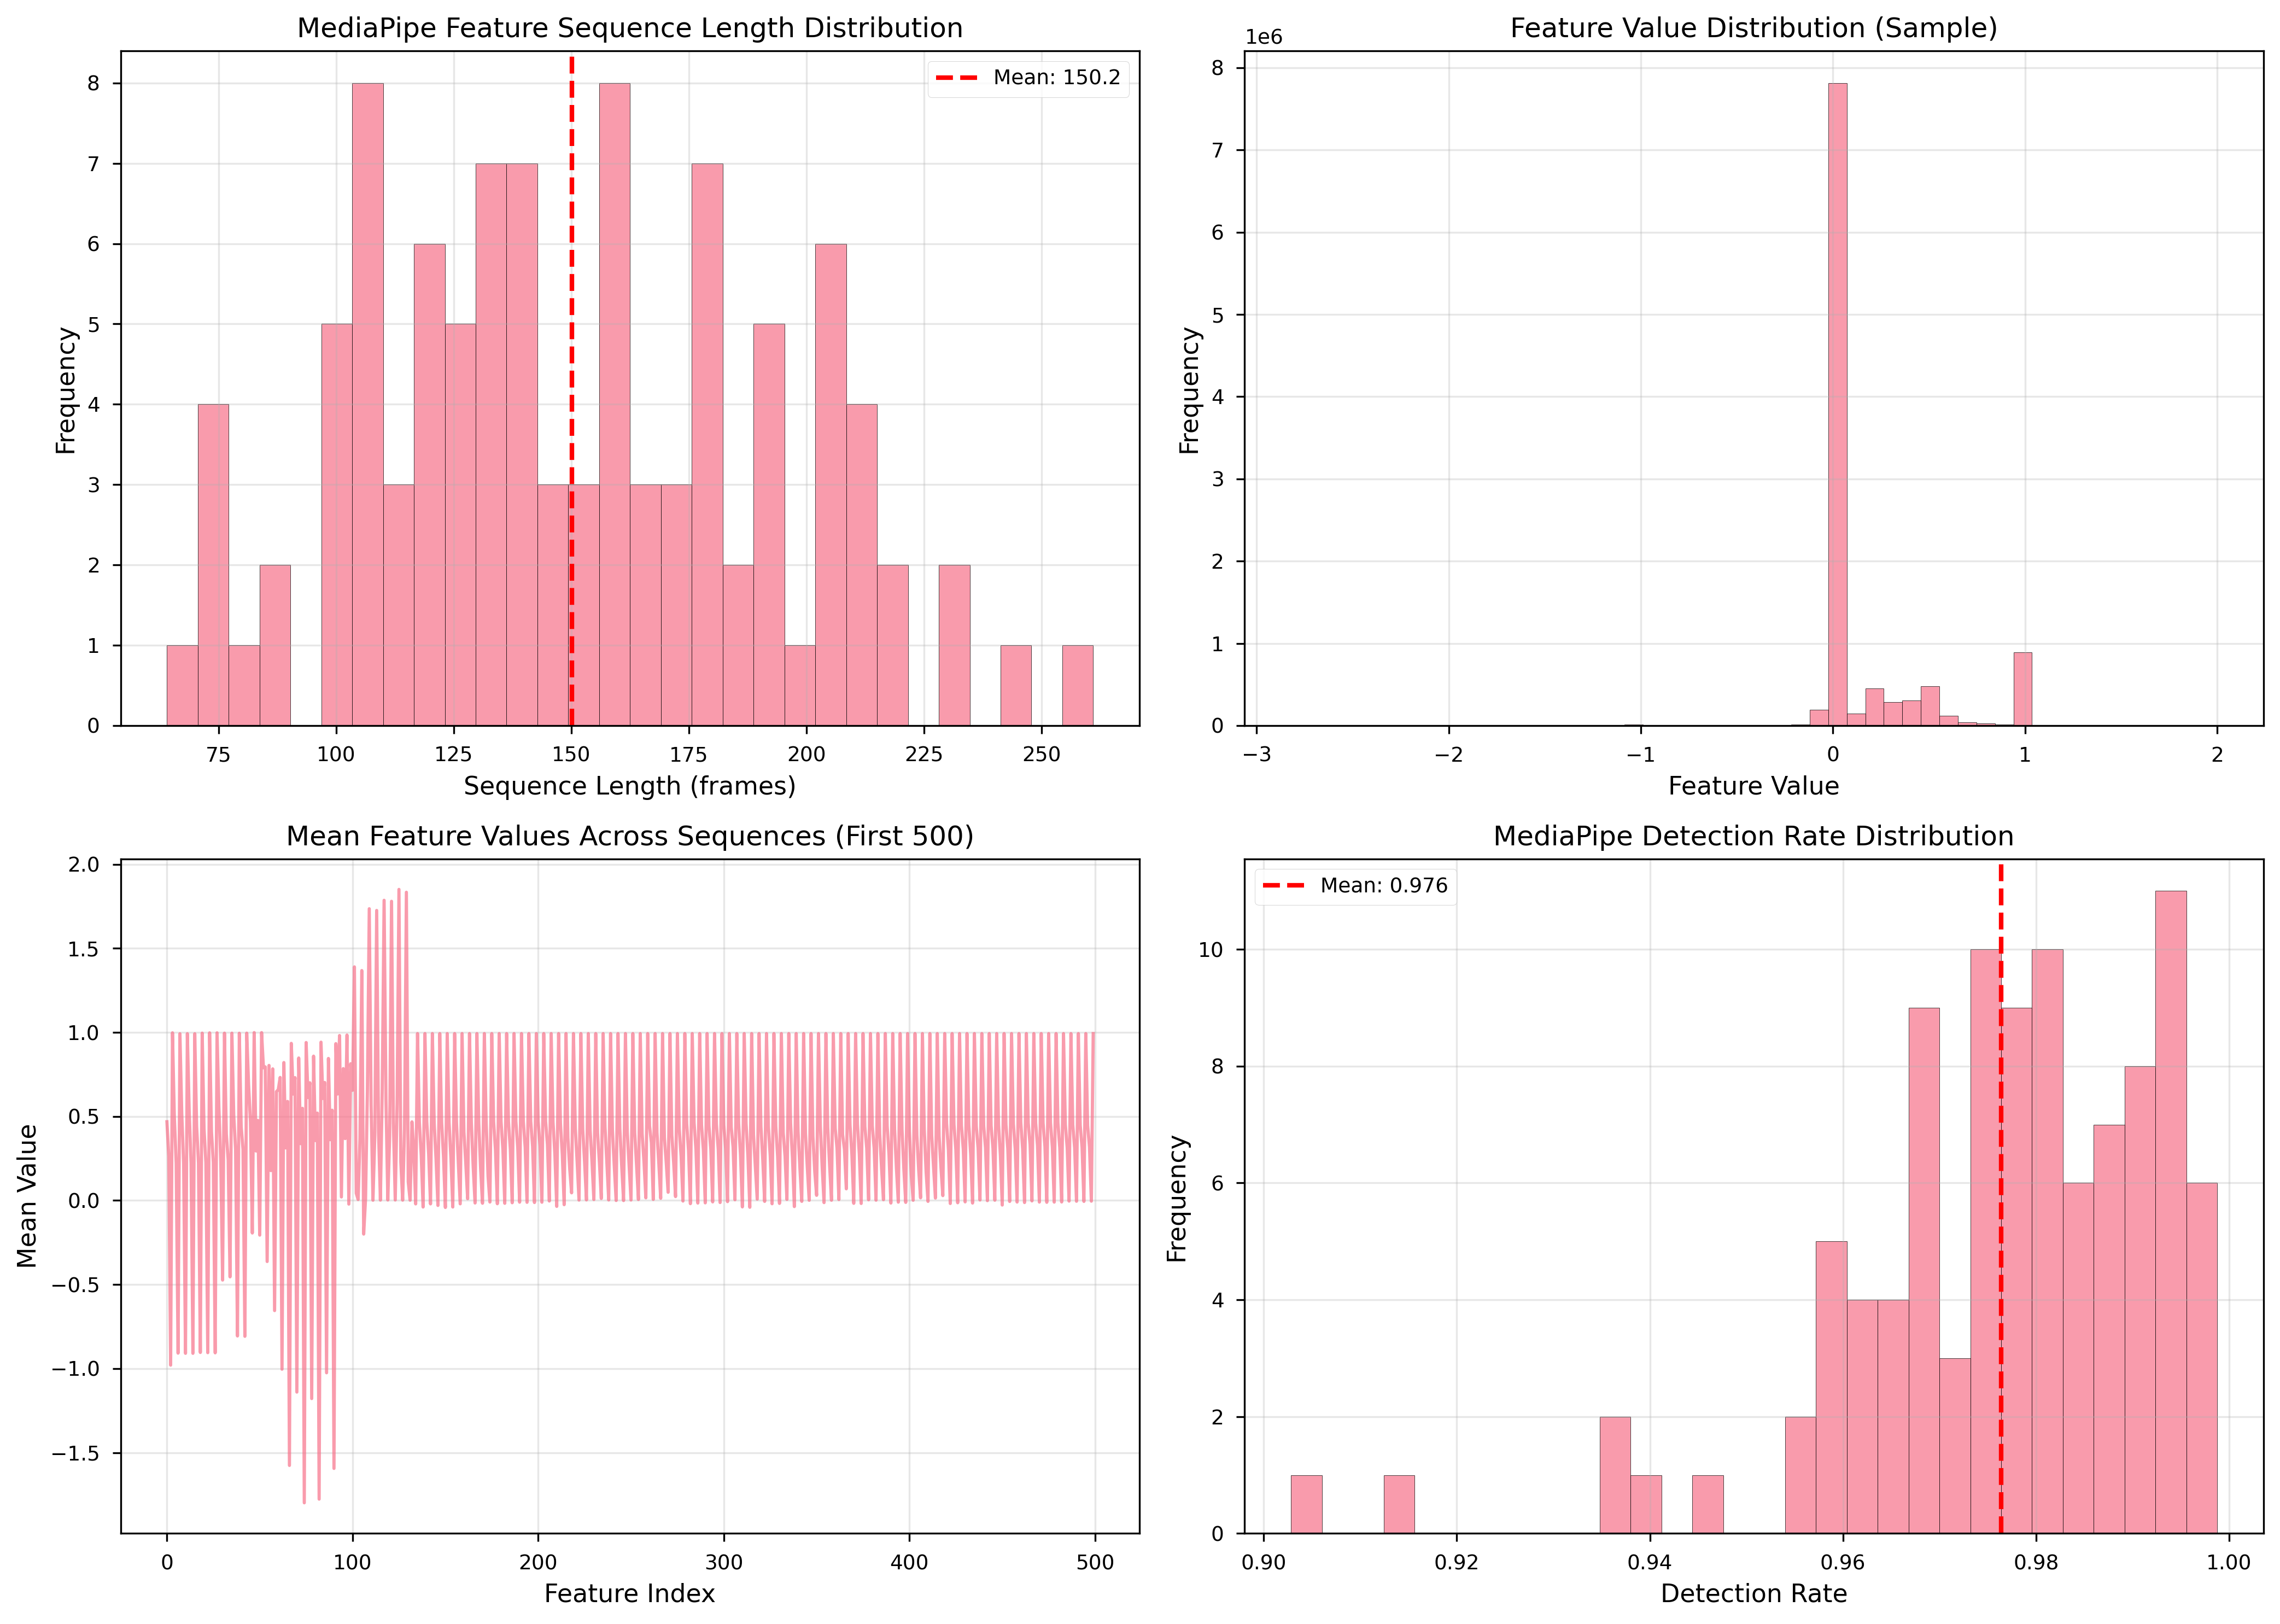

In [32]:
# Visualize feature distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sequence length distribution
axes[0, 0].hist(feature_stats['sequence_lengths'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(feature_stats['sequence_lengths']), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {np.mean(feature_stats["sequence_lengths"]):.1f}')
axes[0, 0].set_xlabel('Sequence Length (frames)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('MediaPipe Feature Sequence Length Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Feature value distribution (sample features)
sample_features_flat = np.concatenate([f.flatten() for f in feature_stats['all_features'][:10]])
axes[0, 1].hist(sample_features_flat, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Feature Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Feature Value Distribution (Sample)')
axes[0, 1].grid(True, alpha=0.3)

# Mean feature values across sequences
mean_features_across_sequences = np.mean(feature_stats['feature_means'], axis=0)
axes[1, 0].plot(mean_features_across_sequences[:500], alpha=0.7)  # First 500 features
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Mean Value')
axes[1, 0].set_title('Mean Feature Values Across Sequences (First 500)')
axes[1, 0].grid(True, alpha=0.3)

# Detection rate if available
if feature_stats['detection_rates'] is not None:
    axes[1, 1].hist(feature_stats['detection_rates'], bins=30, edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(np.mean(feature_stats['detection_rates']), color='red', 
                       linestyle='--', linewidth=2, label=f'Mean: {np.mean(feature_stats["detection_rates"]):.3f}')
    axes[1, 1].set_xlabel('Detection Rate')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('MediaPipe Detection Rate Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Detection masks not available', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('figures/mediapipe_feature_analysis.png', bbox_inches='tight')
plt.show()


## 4. Temporal Pattern Analysis


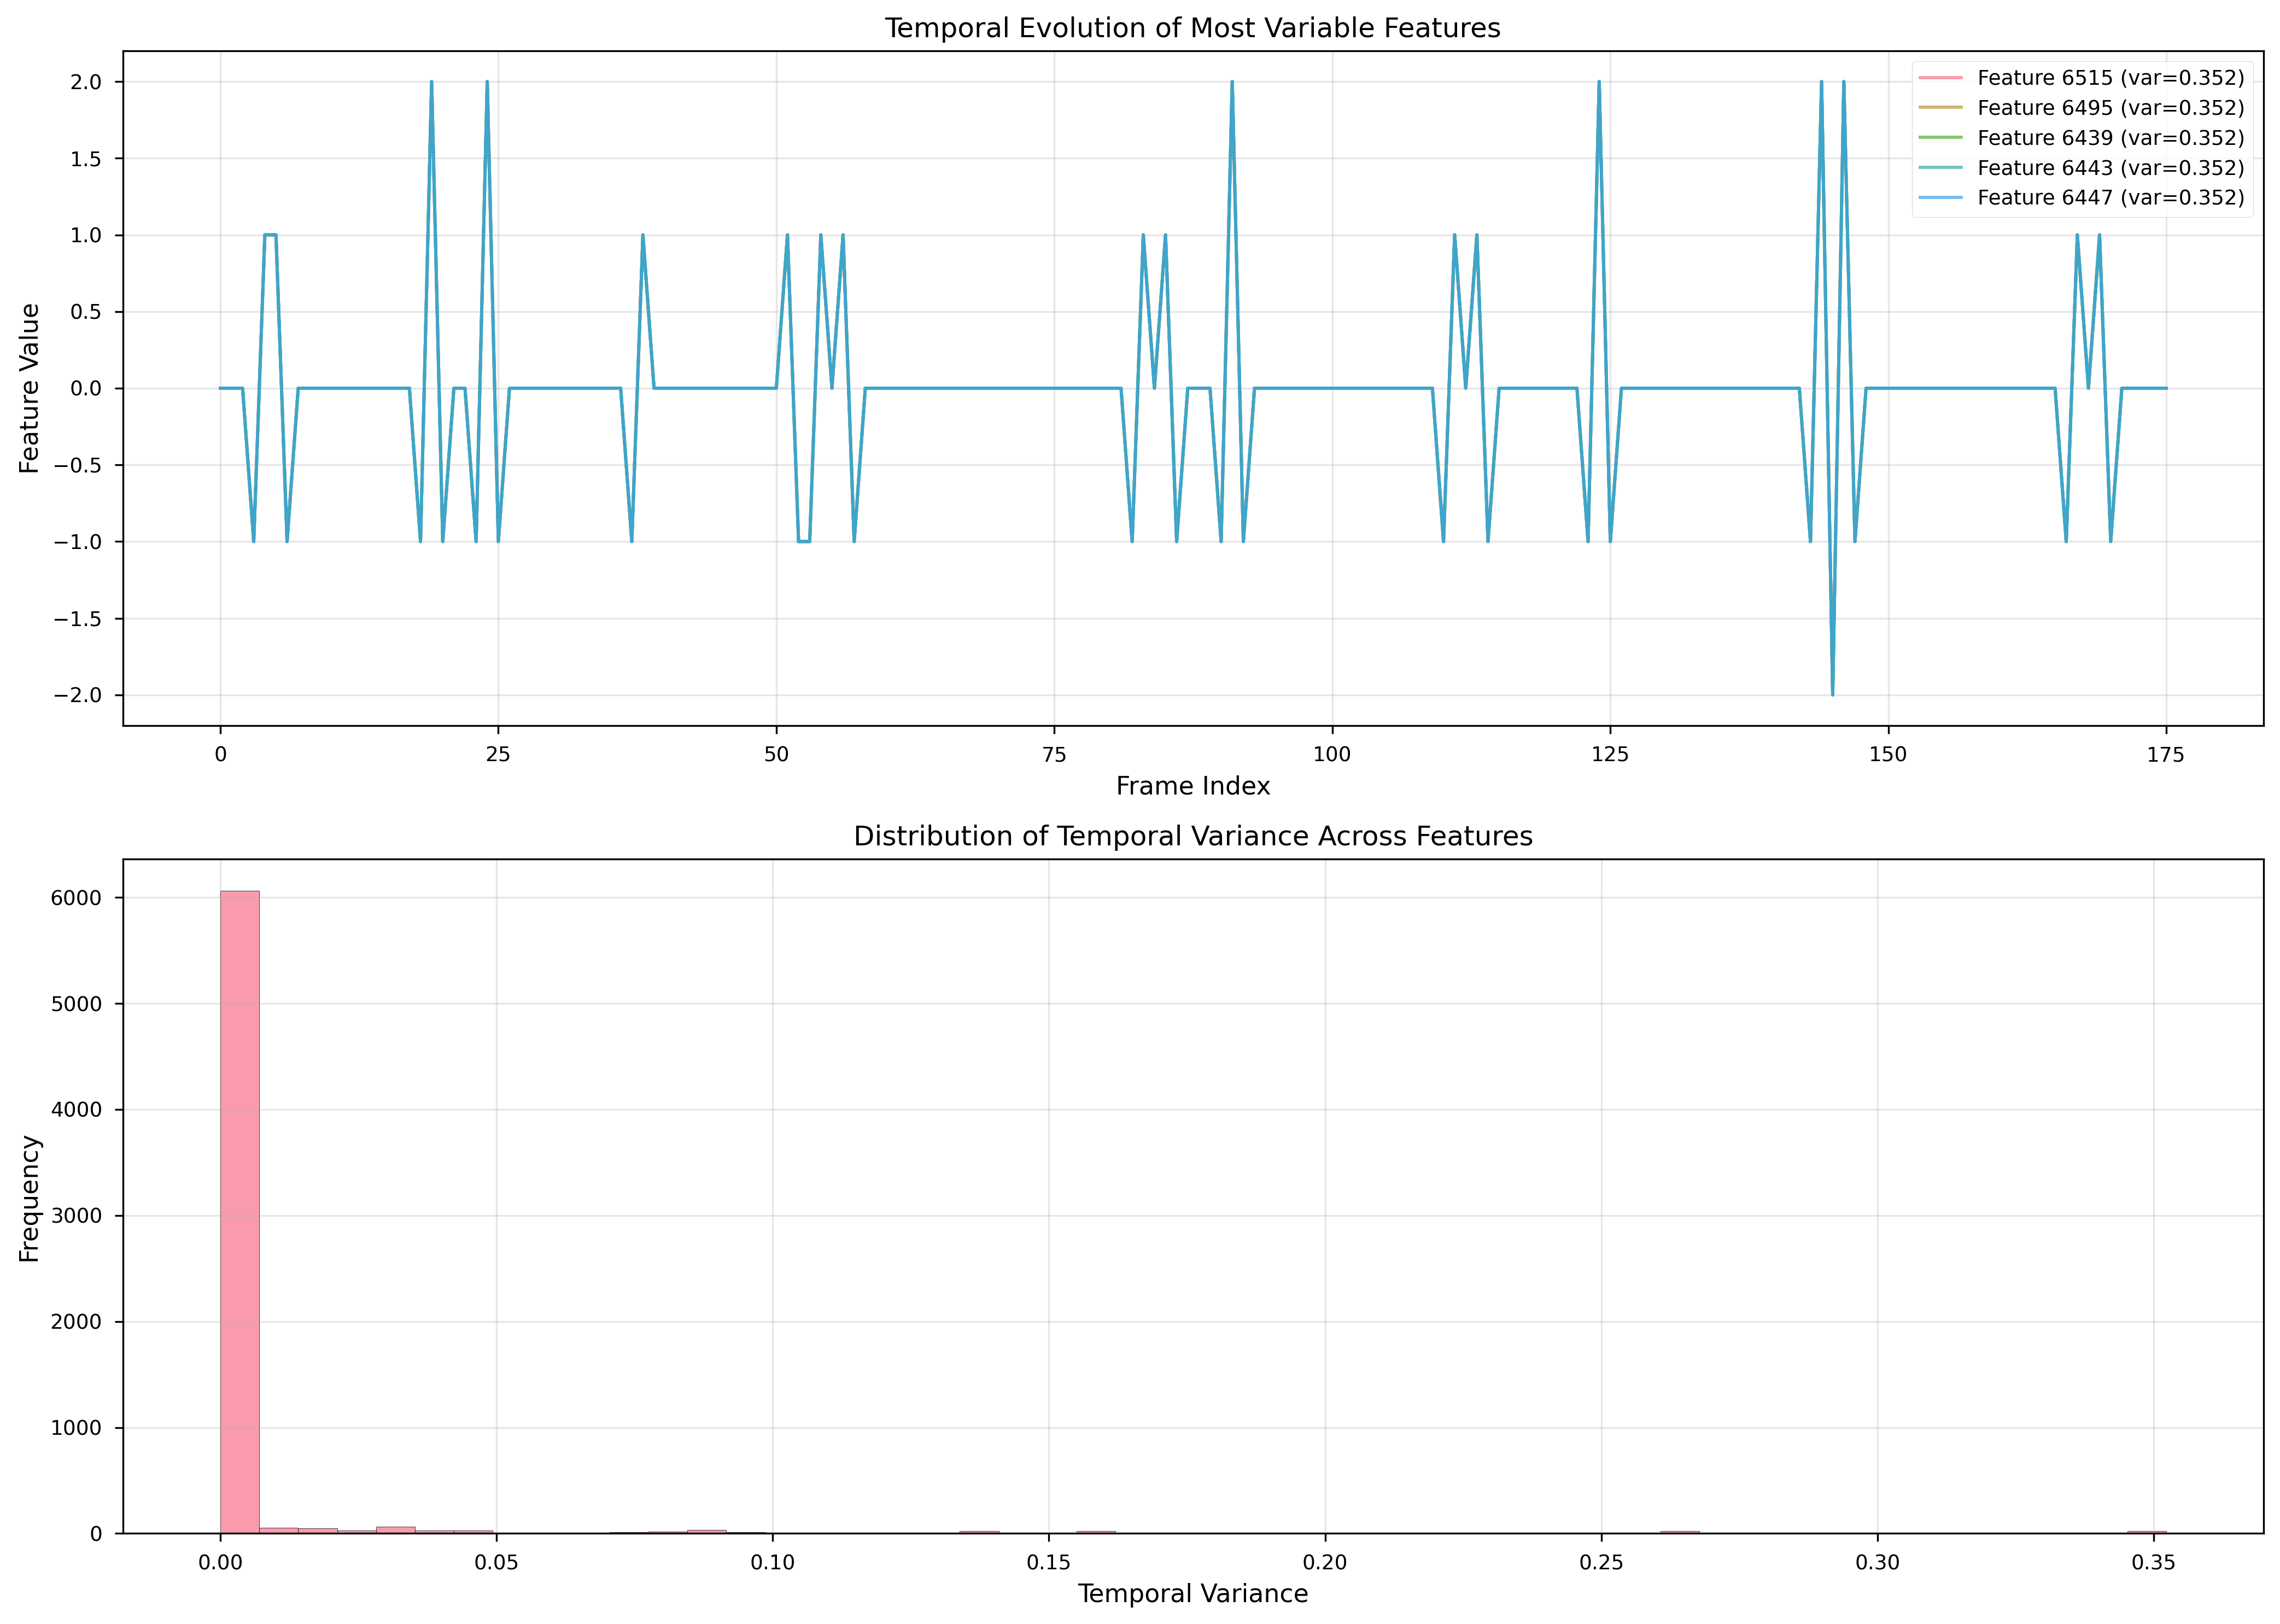

In [33]:
# Analyze temporal patterns in MediaPipe features
def analyze_temporal_patterns(features, num_features_to_plot=10):
    """Analyze how features change over time"""
    # Compute temporal variance for each feature dimension
    temporal_var = np.var(features, axis=0)
    temporal_mean = np.mean(features, axis=0)
    
    # Find most variable features
    top_variable_indices = np.argsort(temporal_var)[-num_features_to_plot:][::-1]
    
    return {
        'temporal_variance': temporal_var,
        'temporal_mean': temporal_mean,
        'top_variable_indices': top_variable_indices
    }

# Analyze temporal patterns for a sample sequence
if sample_features:
    temporal_analysis = analyze_temporal_patterns(sample_features['features'], num_features_to_plot=10)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot temporal evolution of most variable features
    for idx in temporal_analysis['top_variable_indices'][:5]:
        axes[0].plot(sample_features['features'][:, idx], 
                     label=f'Feature {idx} (var={temporal_analysis["temporal_variance"][idx]:.3f})',
                     alpha=0.7)
    axes[0].set_xlabel('Frame Index')
    axes[0].set_ylabel('Feature Value')
    axes[0].set_title('Temporal Evolution of Most Variable Features')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot temporal variance distribution
    axes[1].hist(temporal_analysis['temporal_variance'], bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Temporal Variance')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Temporal Variance Across Features')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/temporal_pattern_analysis.png', bbox_inches='tight')
    plt.show()


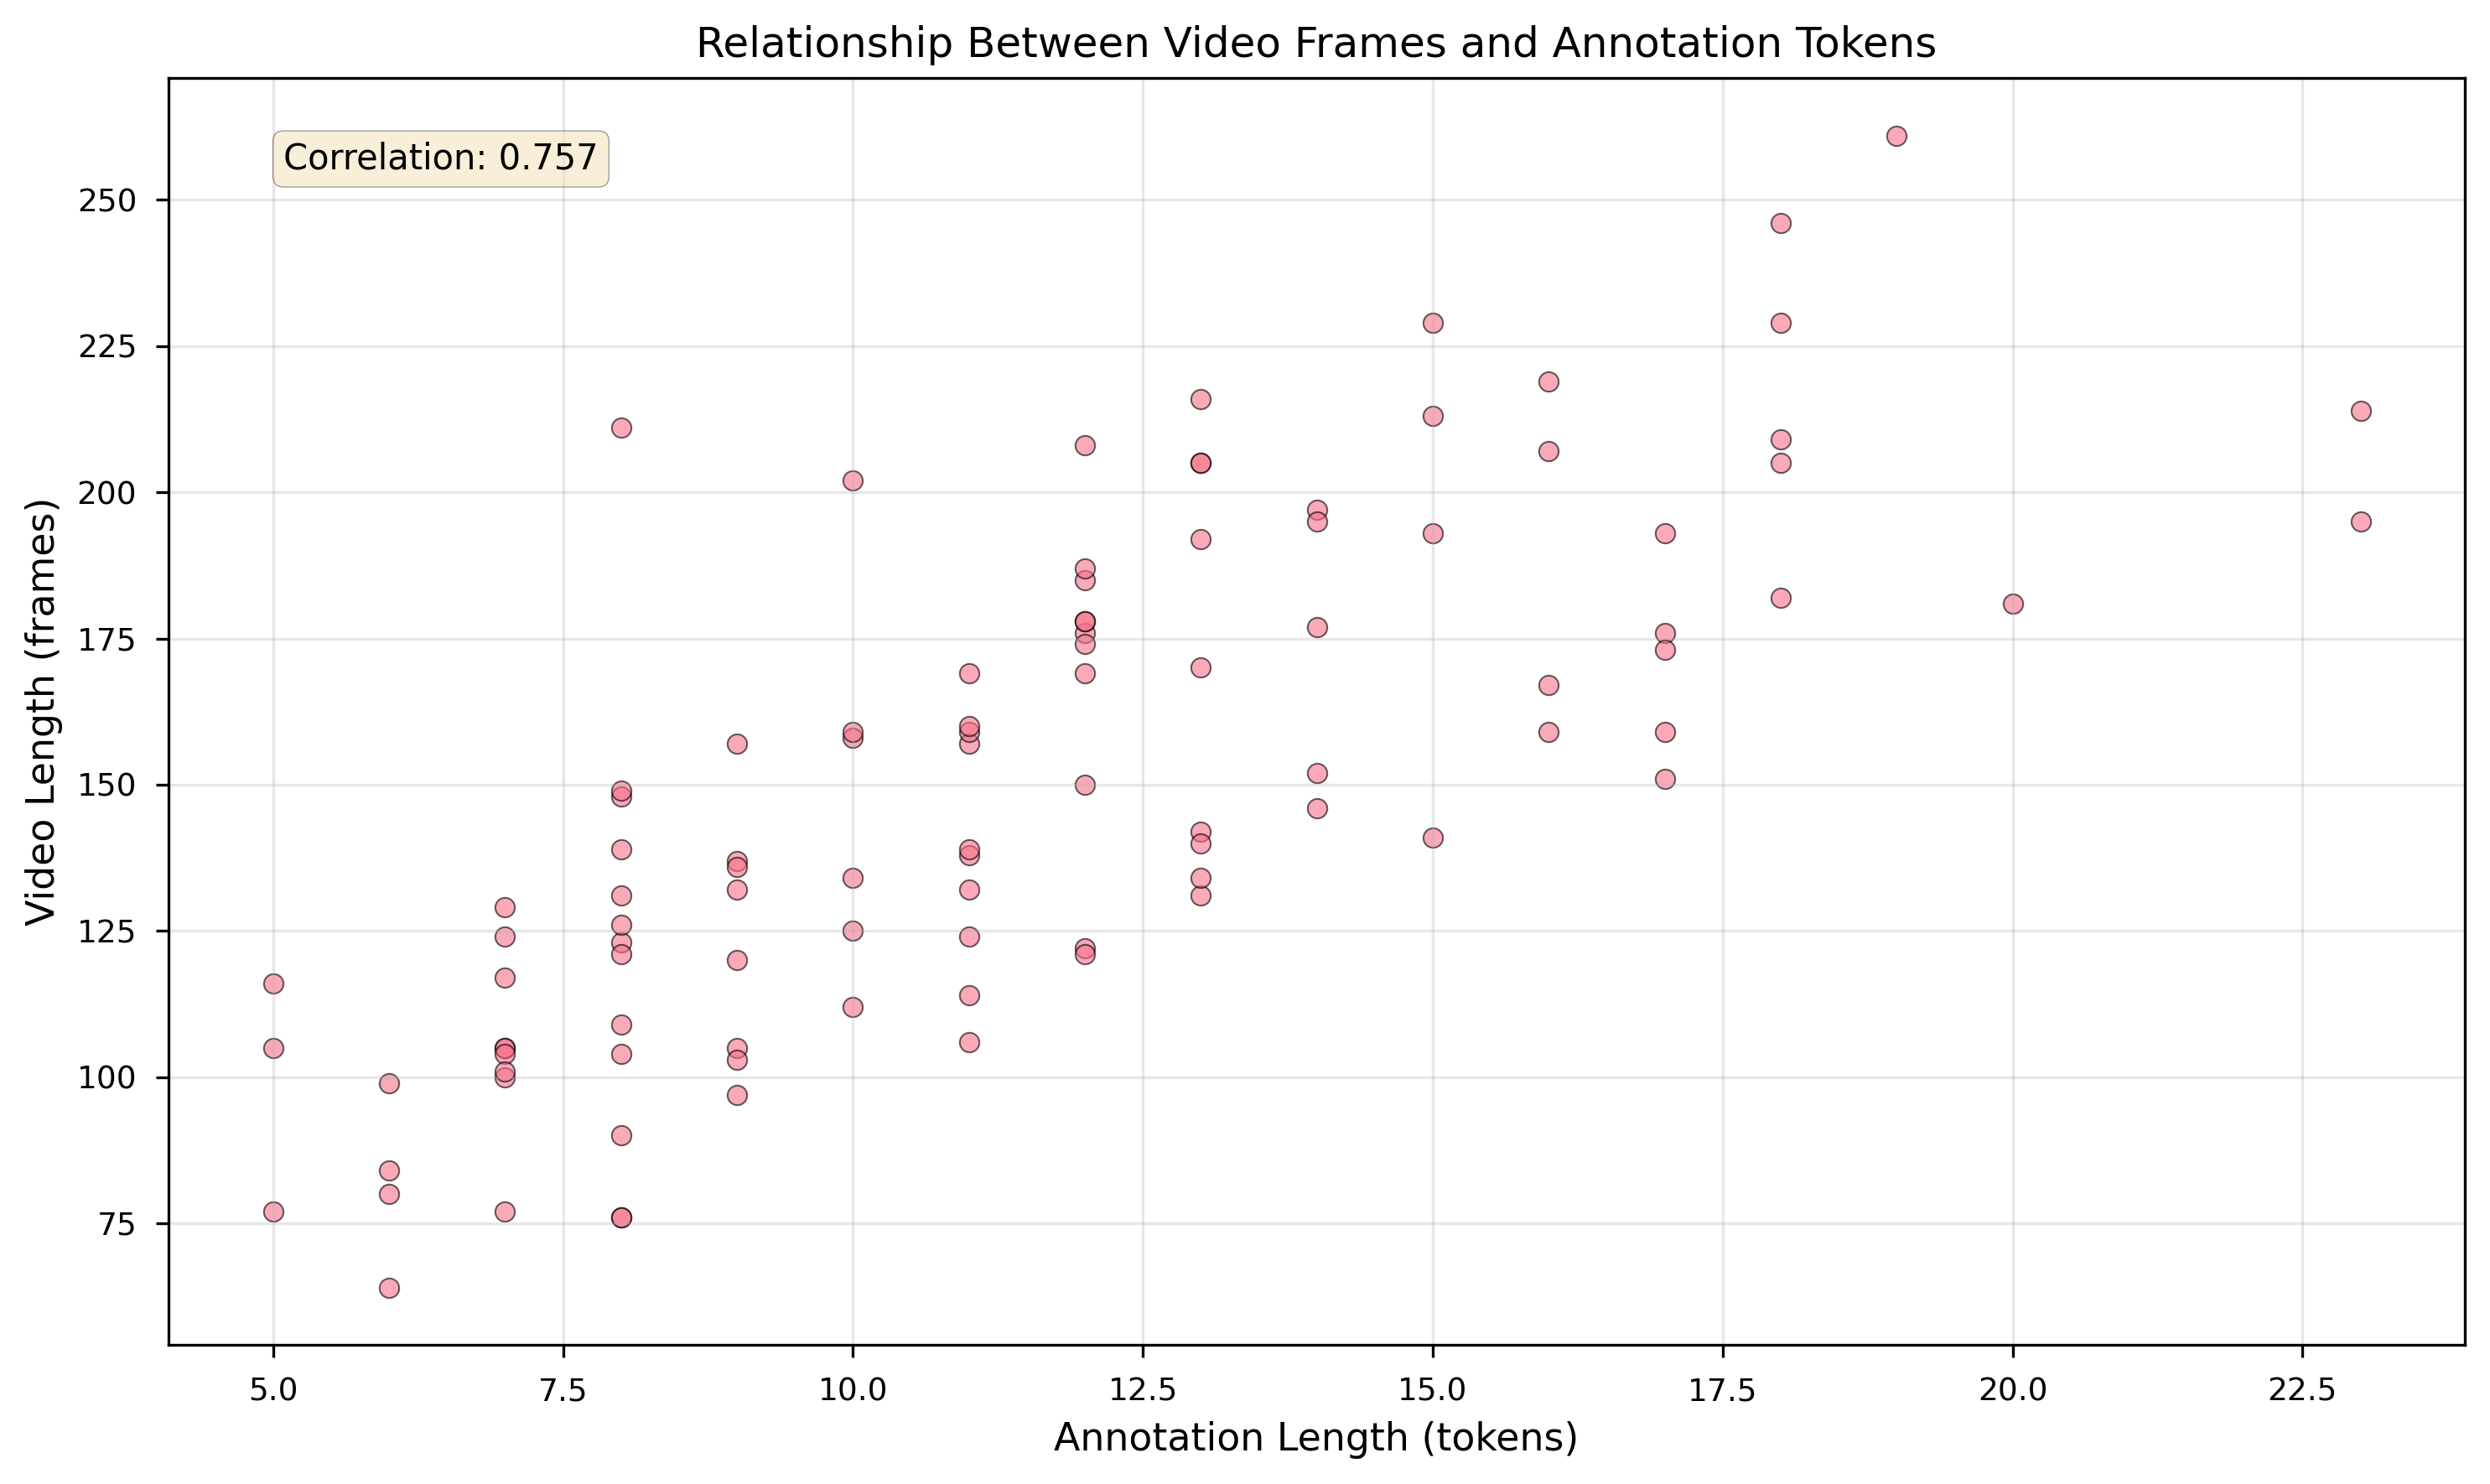


=== Frame-Token Alignment Analysis ===
Correlation coefficient: 0.757
Average frames per token: 13.61
Std frames per token: 3.14


In [34]:
# Correlation analysis between sequence length and annotation length
def analyze_sequence_alignment(num_samples=100):
    """Analyze alignment between video frames and annotation tokens"""
    feature_dir = MEDIAPIPE_FEATURES / 'train'
    feature_files = list(feature_dir.glob('*.npz'))[:num_samples]
    
    frame_lengths = []
    token_lengths = []
    video_ids = []
    
    for feature_file in feature_files:
        video_id = feature_file.stem
        data = np.load(feature_file, allow_pickle=True)
        features = data['features']
        
        frame_lengths.append(features.shape[0])
        video_ids.append(video_id)
        
        # Get corresponding annotation
        if video_id in train_df['id'].values:
            annotation = train_df[train_df['id'] == video_id]['annotation'].values[0]
            token_lengths.append(len(annotation.split()))
        else:
            token_lengths.append(None)
    
    # Filter out None values
    valid_indices = [i for i, t in enumerate(token_lengths) if t is not None]
    frame_lengths = [frame_lengths[i] for i in valid_indices]
    token_lengths = [token_lengths[i] for i in valid_indices]
    
    return np.array(frame_lengths), np.array(token_lengths)

frame_lengths, token_lengths = analyze_sequence_alignment(num_samples=100)

# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(token_lengths, frame_lengths, alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Annotation Length (tokens)')
ax.set_ylabel('Video Length (frames)')
ax.set_title('Relationship Between Video Frames and Annotation Tokens')

# Add correlation coefficient
correlation = np.corrcoef(token_lengths, frame_lengths)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/frame_token_alignment.png', bbox_inches='tight')
plt.show()

print(f"\n=== Frame-Token Alignment Analysis ===")
print(f"Correlation coefficient: {correlation:.3f}")
print(f"Average frames per token: {np.mean(frame_lengths / token_lengths):.2f}")
print(f"Std frames per token: {np.std(frame_lengths / token_lengths):.2f}")


## 5. MediaPipe Landmark Breakdown


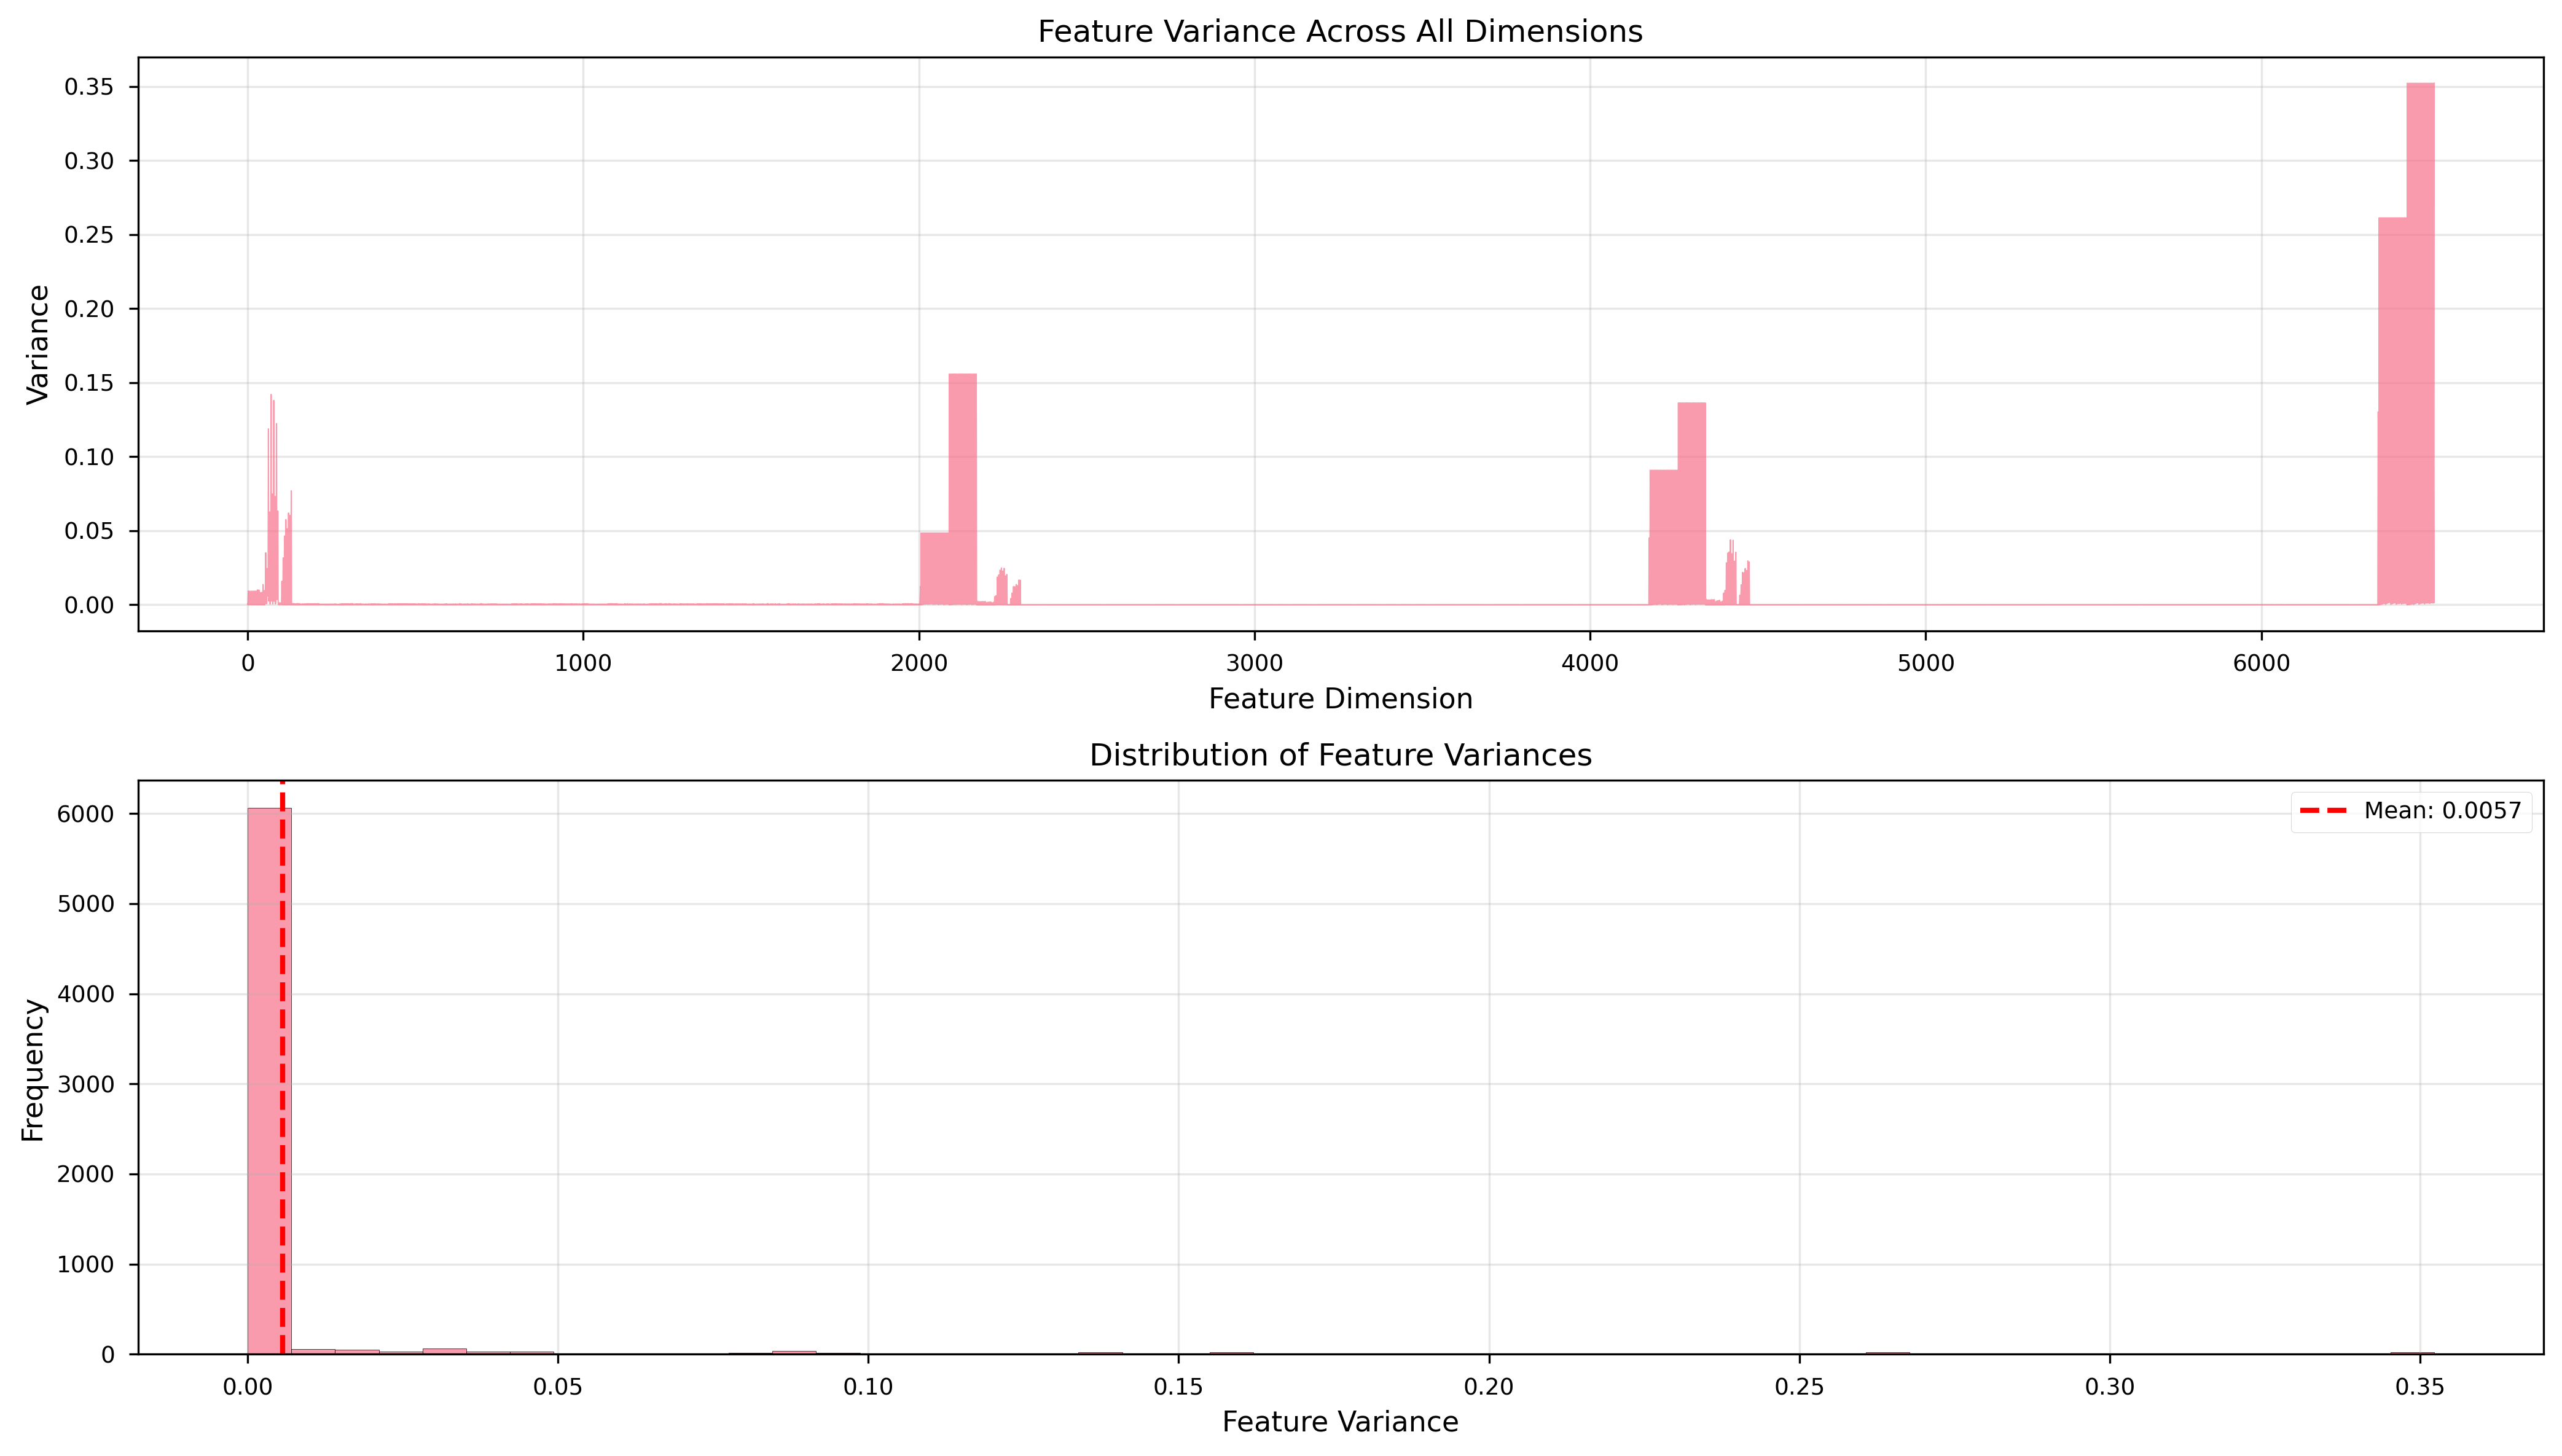


=== Feature Informativeness Analysis ===
Mean variance: 0.0057
Std variance: 0.0301
Min variance: 0.0000
Max variance: 0.3523

Features with variance > 2×mean: 424


In [35]:
# Analyze MediaPipe landmark structure (pose, hands, face)
def visualize_landmark_structure(features):
    """Visualize which parts of MediaPipe features are most informative"""
    num_features = features.shape[1]
    
    # Compute variance for each feature dimension
    feature_variance = np.var(features, axis=0)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Plot feature variance across all dimensions
    axes[0].plot(feature_variance, alpha=0.7, linewidth=0.5)
    axes[0].set_xlabel('Feature Dimension')
    axes[0].set_ylabel('Variance')
    axes[0].set_title('Feature Variance Across All Dimensions')
    axes[0].grid(True, alpha=0.3)
    
    # Histogram of variances
    axes[1].hist(feature_variance, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(feature_variance), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {np.mean(feature_variance):.4f}')
    axes[1].set_xlabel('Feature Variance')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Feature Variances')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/landmark_structure_analysis.png', bbox_inches='tight')
    plt.show()
    
    return feature_variance

if sample_features:
    feature_variance = visualize_landmark_structure(sample_features['features'])
    
    print(f"\n=== Feature Informativeness Analysis ===")
    print(f"Mean variance: {np.mean(feature_variance):.4f}")
    print(f"Std variance: {np.std(feature_variance):.4f}")
    print(f"Min variance: {np.min(feature_variance):.4f}")
    print(f"Max variance: {np.max(feature_variance):.4f}")
    print(f"\nFeatures with variance > 2×mean: {np.sum(feature_variance > 2*np.mean(feature_variance))}")


## 6. Signer Analysis


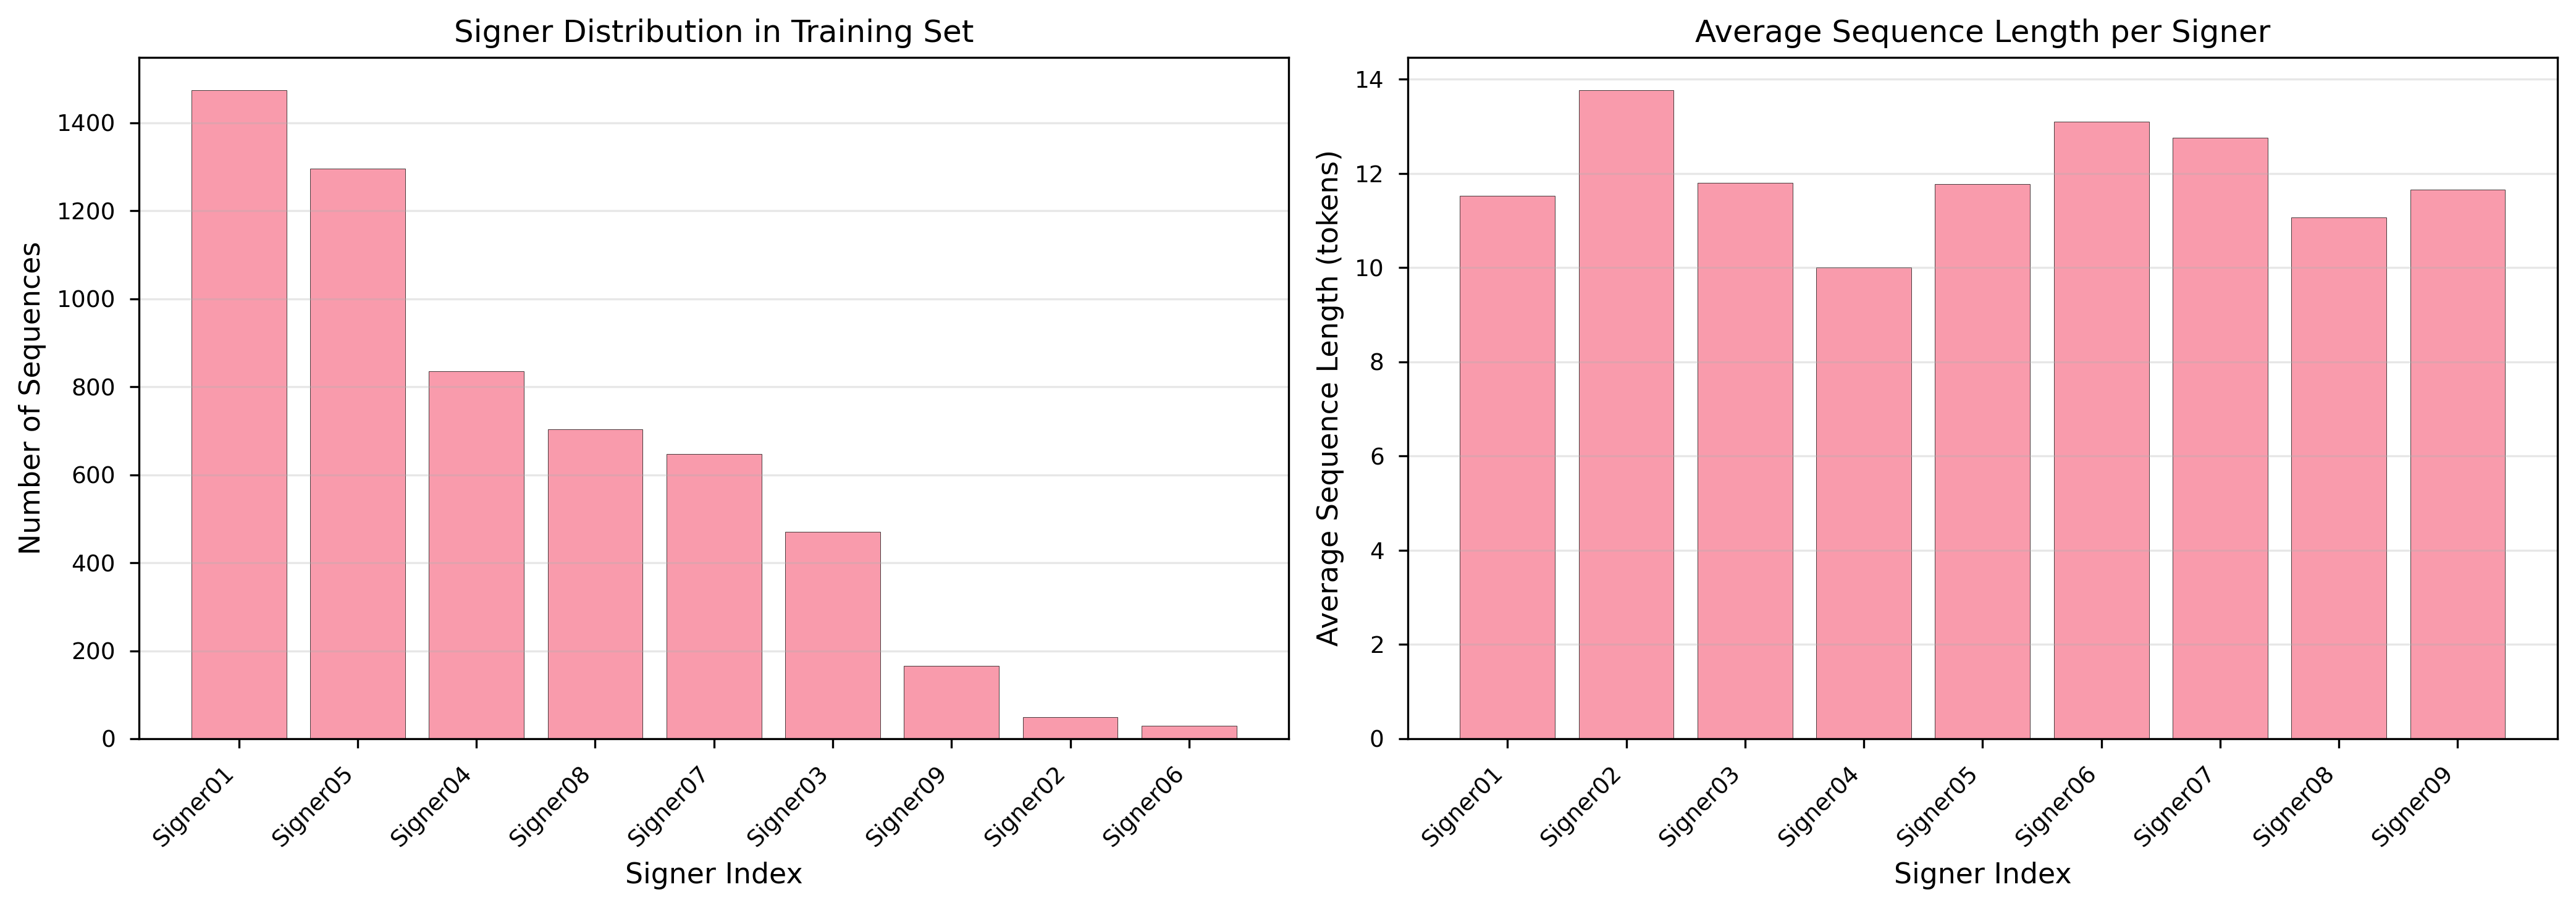


=== Signer Statistics ===
Number of unique signers: 9
Sequences per signer (mean): 630.2
Sequences per signer (std): 488.2


In [36]:
# Analyze signer distribution and characteristics
signer_counts = train_df['signer'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Signer distribution
axes[0].bar(range(len(signer_counts)), signer_counts.values, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Signer Index')
axes[0].set_ylabel('Number of Sequences')
axes[0].set_title('Signer Distribution in Training Set')
axes[0].set_xticks(range(len(signer_counts)))
axes[0].set_xticklabels(signer_counts.index, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# Average sequence length per signer
signer_avg_lengths = train_df.groupby('signer').apply(
    lambda x: np.mean([len(ann.split()) for ann in x['annotation']])
)

axes[1].bar(range(len(signer_avg_lengths)), signer_avg_lengths.values, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Signer Index')
axes[1].set_ylabel('Average Sequence Length (tokens)')
axes[1].set_title('Average Sequence Length per Signer')
axes[1].set_xticks(range(len(signer_avg_lengths)))
axes[1].set_xticklabels(signer_avg_lengths.index, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/signer_analysis.png', bbox_inches='tight')
plt.show()

print(f"\n=== Signer Statistics ===")
print(f"Number of unique signers: {len(signer_counts)}")
print(f"Sequences per signer (mean): {np.mean(signer_counts.values):.1f}")
print(f"Sequences per signer (std): {np.std(signer_counts.values):.1f}")


## 7. Summary and Insights


In [37]:
# Create comprehensive summary
print("="*80)
print("COMPREHENSIVE DATA ANALYSIS SUMMARY")
print("="*80)

print("\n1. DATASET OVERVIEW")
print(f"   - Total sequences: {len(train_df) + len(dev_df) + len(test_df)}")
print(f"   - Training: {len(train_df)} sequences")
print(f"   - Development: {len(dev_df)} sequences")
print(f"   - Test: {len(test_df)} sequences")
print(f"   - Vocabulary size: {len(all_vocab)} unique signs")
print(f"   - Unique signers: {len(set(list(train_df['signer']) + list(dev_df['signer']) + list(test_df['signer'])))}")

print("\n2. SEQUENCE CHARACTERISTICS")
print(f"   - Average annotation length (train): {train_stats['avg_seq_length']:.1f} tokens")
if 'feature_stats' in locals():
    print(f"   - Average video length (samples): {np.mean(feature_stats['sequence_lengths']):.1f} frames")
if 'frame_lengths' in locals() and len(frame_lengths) > 0:
    print(f"   - Frames per token ratio: {np.mean(frame_lengths / token_lengths):.2f}")

print("\n3. MEDIAPIPE FEATURES")
if sample_features:
    print(f"   - Feature dimensions per frame: {sample_features['features'].shape[1]}")
    print(f"   - Memory reduction: ~80% compared to raw video (210×260×3 = 163,800 pixels)")
    print(f"   - Feature format: Spatial landmarks (pose, hands, face)")

print("\n4. KEY INSIGHTS FOR MODEL DESIGN")
print("   - Temporal sequences vary significantly in length")
print("   - MediaPipe features provide compact representation")
if 'frame_lengths' in locals() and len(frame_lengths) > 0:
    print("   - Variable frame-to-token ratio suggests need for temporal modeling")
print("   - Multiple signers require signer-independent modeling")
print("   - Large vocabulary (>1000 signs) requires robust feature extraction")

print("\n5. RECOMMENDATIONS")
print("   - Use variable-length sequence handling (padding/masking)")
print("   - Implement temporal modeling (LSTM/Transformer) for long-range dependencies")
print("   - Consider attention mechanisms for variable-length sequences")
print("   - Apply sequence normalization for signer independence")
print("   - Use CTC loss for unsegmented sequence learning")

print("\n" + "="*80)
print("\nFigures saved to 'figures/' directory")
print("All visualizations are publication-ready for thesis inclusion.")


COMPREHENSIVE DATA ANALYSIS SUMMARY

1. DATASET OVERVIEW
   - Total sequences: 6841
   - Training: 5672 sequences
   - Development: 540 sequences
   - Test: 629 sequences
   - Vocabulary size: 1295 unique signs
   - Unique signers: 9

2. SEQUENCE CHARACTERISTICS
   - Average annotation length (train): 11.5 tokens
   - Average video length (samples): 150.2 frames
   - Frames per token ratio: 13.61

3. MEDIAPIPE FEATURES
   - Feature dimensions per frame: 6516
   - Memory reduction: ~80% compared to raw video (210×260×3 = 163,800 pixels)
   - Feature format: Spatial landmarks (pose, hands, face)

4. KEY INSIGHTS FOR MODEL DESIGN
   - Temporal sequences vary significantly in length
   - MediaPipe features provide compact representation
   - Variable frame-to-token ratio suggests need for temporal modeling
   - Multiple signers require signer-independent modeling
   - Large vocabulary (>1000 signs) requires robust feature extraction

5. RECOMMENDATIONS
   - Use variable-length sequence han